<a href="https://colab.research.google.com/github/olonok69/Anomaly_detection/blob/master/Anomaly_Detection_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.utils import *

from PIL import Image
import requests
from io import BytesIO
import os
import random
import pickle
import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/colab/XXX/'

In [4]:
df = pd.read_json(root_path + 'Crack.json', lines=True)
df['label'] = df.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
print(df.shape)
df.head()

(1428, 5)


,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [5]:
### GET AND PREPARE IMAGES ###

images = []

for url in tqdm.tqdm(df['content']):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    images.append(img_batch.astype('float16'))
    
images = np.vstack(images)
print(images.shape)

100%|██████████| 1428/1428 [02:06<00:00, 11.29it/s]


(1428, 224, 224, 3)


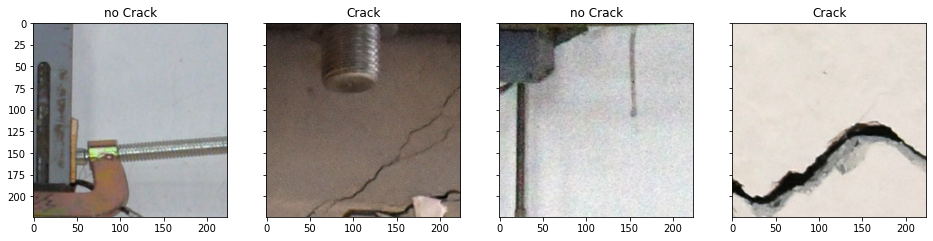

In [6]:
### RANDOM IMAGES PLOT ###

random_id = np.random.randint(0,images.shape[0],4)
f, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize = (16,10))

for ax, img, title in zip(axes.ravel(), images[random_id], df['label'][random_id]):
    ax.imshow(array_to_img(img))
    ax.set_title(title)

In [0]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [9]:
### IMPORT VGG16 ###

vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58892288/58889256 [==============================] - 0s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2d245b95c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d240fd470> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d240fd7b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2d77ccc9b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d1e5bd438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d1e5ce780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2d1e5d3940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d1e5d37b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d1e5dbb00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d1c560278> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2d1c564898> Fals

In [0]:
### ENCODE LABEL ###

Y = to_categorical((df.label.values == 'Crack')+0)

In [0]:
### CREATE TRAIN TEST ###

X_train, X_test, y_train, y_test = train_test_split(images, Y, random_state = 42, test_size=0.2)

In [13]:
### MODIFY VGG STRUCTURE ###

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)

model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
### INITIALIZE TRAIN GENERATOR ###

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        fill_mode = "nearest",
        zoom_range = 0.3,
        width_shift_range = 0.3,
        height_shift_range=0.3,
        rotation_range=30
)

In [0]:
### FIT TRAIN GENERATOR ###

train_datagen.fit(X_train)

In [16]:
# INICIALIZAR LA SESSION ANTES DE CARGAL el modelo. 


# tf.random.set_random_seed(33)
# os.environ['PYTHONHASHSEED'] = str(33)
# np.random.seed(33)
# random.seed(33)

# session_conf = tf.compat.v1.ConfigProto(
#     intra_op_parallelism_threads=1, 
#     inter_op_parallelism_threads=1
# )
# sess = tf.compat.v1.Session(
#     graph=tf.compat.v1.get_default_graph(), 
#     config=session_conf
# )
# tf.compat.v1.keras.backend.set_session(sess)


model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
36/35 [==============================] - 1130s 31s/step - loss: 0.7213 - accuracy: 0.5131
Epoch 2/20
36/35 [==============================] - 1121s 31s/step - loss: 0.6386 - accuracy: 0.6953
Epoch 3/20
36/35 [==============================] - 1147s 32s/step - loss: 0.5939 - accuracy: 0.7636
Epoch 4/20
36/35 [==============================] - 1120s 31s/step - loss: 0.5427 - accuracy: 0.8135
Epoch 5/20
36/35 [==============================] - 1102s 31s/step - loss: 0.4897 - accuracy: 0.8109
Epoch 6/20
36/35 [==============================] - 1098s 30s/step - loss: 0.4587 - accuracy: 0.8056
Epoch 7/20
36/35 [==============================] - 1156s 32s/step - loss: 0.4043 - accuracy: 0.8406
Epoch 8/20
36/35 [==============================] - 1117s 31s/step - loss: 0.3808 - accuracy: 0.8336
Epoch 9/20
36/35 [==============================] - 1116s 31s/step - loss: 0.3482 - accuracy: 0.8660
Epoch 10/20
36/

In [17]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       162
           1       0.95      0.81      0.88       124

    accuracy                           0.90       286
   macro avg       0.91      0.89      0.90       286
weighted avg       0.91      0.90      0.90       286



In [0]:
### CREATE FUNCTION TO DRAW ANOMALIES ###

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

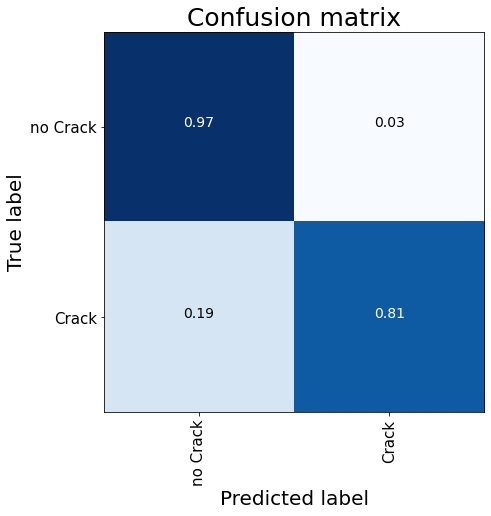

In [19]:
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=df.label.unique(), title="Confusion matrix")
plt.show()

In [0]:
def plot_activation(img):
  
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0] #weights last classification layer
    class_weights = weights[:, pred_class]

    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])

    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(img.shape[0],img.shape[1])

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

    #return out, pred_class

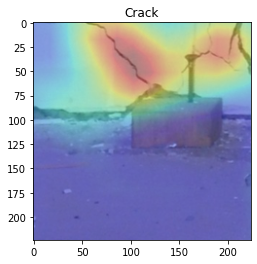

In [21]:
plot_activation(X_test[200]/255)

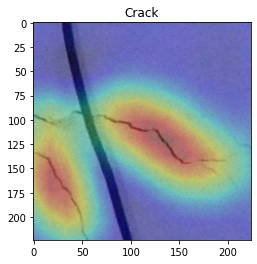

In [22]:
plot_activation(X_test[100]/255)

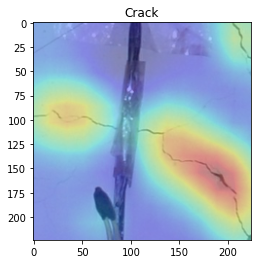

In [23]:
plot_activation(X_test[134]/255)